# March 3-10, 2022: emoprox2 approach vs retreat segments classification

In [57]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import tensorflow as tf
# import tensorflow_addons as tfa
import pickle, time, random
import neural_structured_learning as nsl
from tqdm import tqdm

# explanation tools
import shap

# plotting
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

# nilearn
from nilearn import image
from nilearn import masking
from nilearn import plotting

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'explainable-ai')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/mar22"

# folders
sys.path.insert(0, proj_dir)
from helpers.dataset_utils import *
from helpers.base_model import *
from helpers.model_definitions import *

# select the GPU to be used
gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_memory_growth(gpus[1], True)
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# print the JS visualization code to the notebook
shap.initjs()

## data 

In [2]:
def get_data_samples_actual(data, subject_list):
    
    X = []; y = []
    target = np.expand_dims(np.array([0,0,0,0,0,0,0,1,1,1,1,1]),axis=0).astype(np.float64)
    
    for subject in subject_list:
        
        num_samples = data[subject].shape[0]
        X.append(data[subject])
        y.append(np.repeat(target, num_samples, axis=0))

    return np.vstack(X), np.vstack(y)

def get_data_samples_avg(data, subject_list):
    
    X = []; y = []
    target = np.expand_dims(np.array([0,0,0,0,0,0,0,1,1,1,1,1]),axis=0).astype(np.float64)
    
    for subject in subject_list:
        
        num_samples = data[subject].shape[0]
        X.append(np.expand_dims(np.mean(data[subject], axis=0), axis=0))
        y.append(target)

    return np.vstack(X), np.vstack(y)

In [3]:
raw_data_file = f"{proj_dir}/data/classification_data/MAX_rois_122subjs_nearmiss_segments_withoutshock.pkl"
with open(raw_data_file, 'rb') as f:
    data = pickle.load(f)

### parameters

In [4]:
class ARGS(): pass
args = ARGS()

args.SEED = 74

# data
args.num_subjects = len(data.keys())
args.num_train = args.num_subjects // 2
args.num_test = args.num_subjects - args.num_train

### organizing into tensors

In [5]:
subject_list = list(data.keys())
random.Random(args.SEED).shuffle(subject_list)

train_list = subject_list[:args.num_train]
test_list = subject_list[-args.num_test:]

X_train, y_train = get_data_samples_actual(data, train_list)
X_test, y_test = get_data_samples_actual(data, test_list)

X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)
X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2137, 12, 85) (2137, 12) (2167, 12, 85) (2167, 12)


2022-03-10 19:30:46.613254: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-10 19:30:46.614519: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-03-10 19:30:46.614864: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 1
2022-03-10 19:30:46.614908: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-03-10 19:30:46.999052: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect St

## model

In [6]:
# model
args.num_units = 32
args.num_classes = 2 # for binary classification
args.l2 = 1e-2
args.dropout = 0.8
args.learning_rate = 4e-4

args.num_epochs = 100
args.validation_split = 0.2
args.batch_size = 64

# multiplier to adversarial regularization loss. Defaults to 0.2. 
args.adv_multiplier = 1
# step size to find the adversarial sample. Defaults to 0.001. 
args.adv_step_size = 3
# type of tensor norm to normalize the gradient. Defaults to L2 norm. 
# Input will be converted to NormType when applicable 
# (e.g., a value of 'l2' will be converted to nsl.configs.NormType.L2). 
args.adv_grad_norm = 'l2'

args.temp = 20

### response of near miss segment (proof of concept)

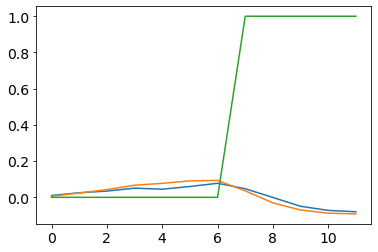

In [7]:
import matplotlib.pyplot as plt
plt.plot(np.mean(np.mean(X_train,axis=2), axis=0))
plt.plot(np.mean(np.mean(X_test,axis=2), axis=0))
plt.plot(np.mean(y_train, axis=0))


### defining model

In [8]:
tf.random.set_seed(args.SEED)

regularizer = tf.keras.regularizers.l2(l2=args.l2) 
optimizer = tf.keras.optimizers.Adam(learning_rate=args.learning_rate)

'''
build model
'''
model = get_GRU_classifier_model(
    X_train, 
    args, 
    regularizer)

'''
train model
'''
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

then = time.time()
history = model.fit(
    x=X_train, 
    y=y_train,
    batch_size=args.batch_size, 
    epochs=args.num_epochs, 
    verbose=1,
    # callbacks=tf.keras.callbacks.EarlyStopping(patience=5),
    validation_split=args.validation_split, 
    shuffle=True)
print('--- train time =  %0.4f seconds ---' %(time.time() - then))

'''
save model
'''
model_file = f"{results_dir}/models/GRU_classifier_model"
model.save(model_file)

2022-03-10 19:30:47.401025: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-10 19:30:47.401683: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699850000 Hz


Epoch 1/100


2022-03-10 19:30:48.709211: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


 5/27 [====>.........................] - ETA: 0s - loss: 2.0236 - sparse_categorical_accuracy: 0.4836

2022-03-10 19:30:49.046072: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


27/27 [==============================] - 3s 64ms/step - loss: 1.9415 - sparse_categorical_accuracy: 0.5012 - val_loss: 1.7678 - val_sparse_categorical_accuracy: 0.5467
Epoch 2/100
27/27 [==============================] - 1s 54ms/step - loss: 1.7644 - sparse_categorical_accuracy: 0.5226 - val_loss: 1.6178 - val_sparse_categorical_accuracy: 0.5750
Epoch 3/100
27/27 [==============================] - 2s 57ms/step - loss: 1.6275 - sparse_categorical_accuracy: 0.5235 - val_loss: 1.4907 - val_sparse_categorical_accuracy: 0.5983
Epoch 4/100
27/27 [==============================] - 2s 57ms/step - loss: 1.5025 - sparse_categorical_accuracy: 0.5313 - val_loss: 1.3817 - val_sparse_categorical_accuracy: 0.6114
Epoch 5/100
27/27 [==============================] - 2s 57ms/step - loss: 1.3941 - sparse_categorical_accuracy: 0.5440 - val_loss: 1.2854 - val_sparse_categorical_accuracy: 0.6273
Epoch 6/100
27/27 [==============================] - 1s 54ms/step - loss: 1.3009 - sparse_categorical_accuracy: 

2022-03-10 19:33:21.681523: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/govindas/explainable-ai/results/models/GRU_classifier_model/assets


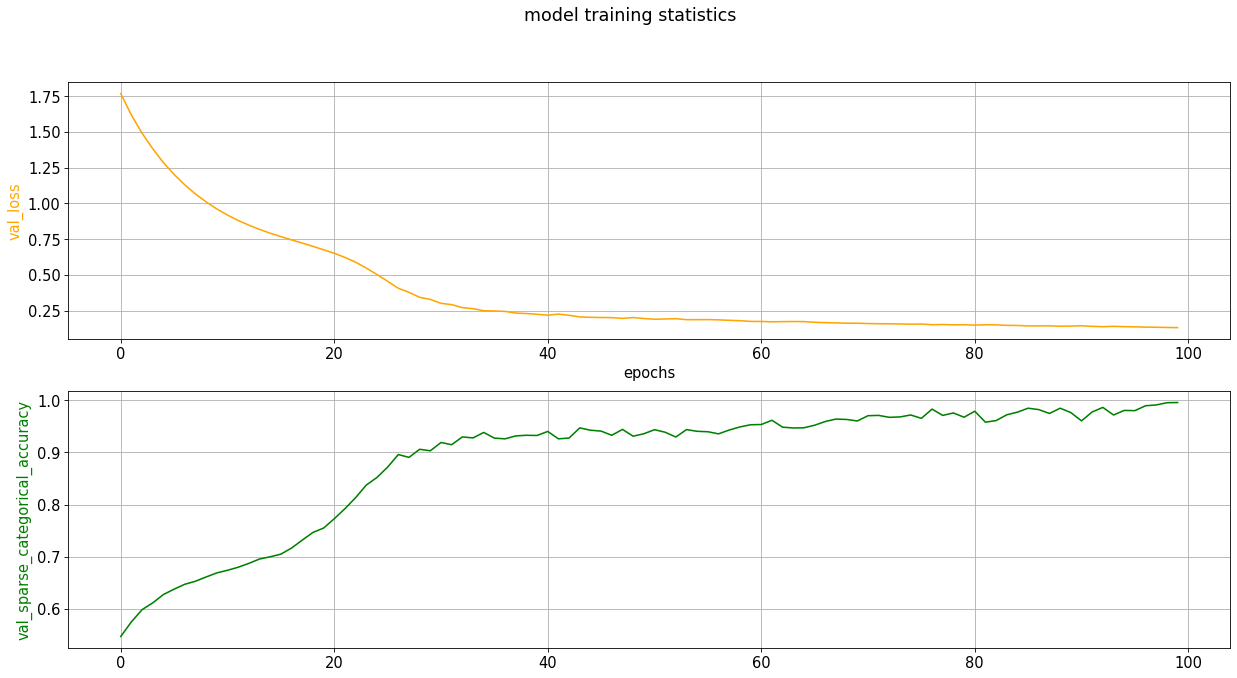

In [9]:
cm = 1 #1/2.54
nrows, ncols = 2, 1
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(20*ncols*cm, 5*nrows*cm), 
    sharex=False,
    sharey=False,
    dpi=75)

plt.suptitle(f"model training statistics")

ax = axs[0]
ax.plot(history.history['val_loss'], color='orange')
ax.set_ylabel(f"val_loss", color='orange')
ax.set_xlabel(f"epochs")
ax.grid(True, axis='both')

ax = axs[1]
ax.plot(history.history['val_sparse_categorical_accuracy'], color='green')
ax.set_ylabel(f"val_sparse_categorical_accuracy", color='green')
ax.grid(True, axis='both')

In [10]:
model.evaluate(X_test, y_test)

68/68 [==============================] - 1s 11ms/step - loss: 0.1315 - sparse_categorical_accuracy: 0.9947


[0.13145098090171814, 0.994731605052948]

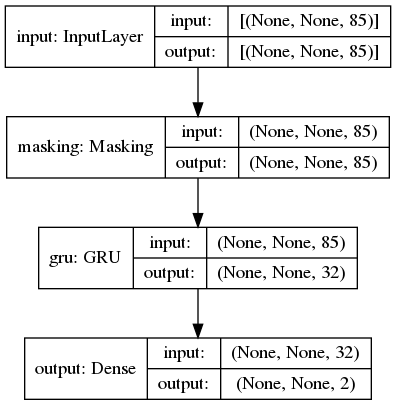

In [11]:
tf.keras.utils.plot_model(
    model, 
    f"figures/GRU_classifier_model.png", 
    show_shapes=True)

In [12]:
model.summary()

Model: "GRU_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None, 85)]        0         
_________________________________________________________________
masking (Masking)            (None, None, 85)          0         
_________________________________________________________________
gru (GRU)                    (None, None, 32)          11424     
_________________________________________________________________
output (Dense)               (None, None, 2)           66        
Total params: 11,490
Trainable params: 11,490
Non-trainable params: 0
_________________________________________________________________


### adversarial-regularized model

In [13]:
'''
base model
'''
base_model = get_GRU_classifier_model(
    X_train, 
    args, 
    regularizer)

'''
configurations
'''
adv_config = nsl.configs.make_adv_reg_config(
    multiplier=args.adv_multiplier,
    adv_step_size=args.adv_step_size,
    adv_grad_norm=args.adv_grad_norm,
#     pgd_iterations=3,
#     pgd_epsilon=0.001
)

'''
building adv-model
'''
adv_model = nsl.keras.AdversarialRegularization(
    base_model,
    label_keys=['label'],
    adv_config=adv_config
)

'''
training
'''
adv_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

then = time.time()
adv_history = adv_model.fit(
    x={'input': X_train, 'label': y_train}, 
    epochs=args.num_epochs,
    validation_split=args.validation_split,
    batch_size=args.batch_size,
    verbose=1)
print('--- train time =  %0.4f seconds ---' %(time.time() - then))

'''
saving model
'''
# cannot save adv-model yet
# but may save its base model

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
27/27 [==============================] - 11s 129ms/step - loss: 2.4228 - sparse_categorical_accuracy: 0.5315 - sparse_categorical_crossentropy: 0.7379 - scaled_adversarial_loss: 0.7739 - val_loss: 2.1171 - val_sparse_categorical_accuracy: 0.6431 - val_sparse_categorical_crossentropy: 0.6456 - val_scaled_adversarial_loss: 0.8540
Epoch 2/100
27/27 [==============================] - 3s 93ms/step - loss: 1.8526 - sparse_categorical_accuracy: 0.5714 - sparse_categorical_crossentropy: 0.6878 - scaled_adversarial_loss: 0.6983 - val_loss: 1.7731 - val_sparse_categorical_accuracy: 0.6591 - val_sparse_categorical_crossentropy: 0.63

'\nsaving model\n'

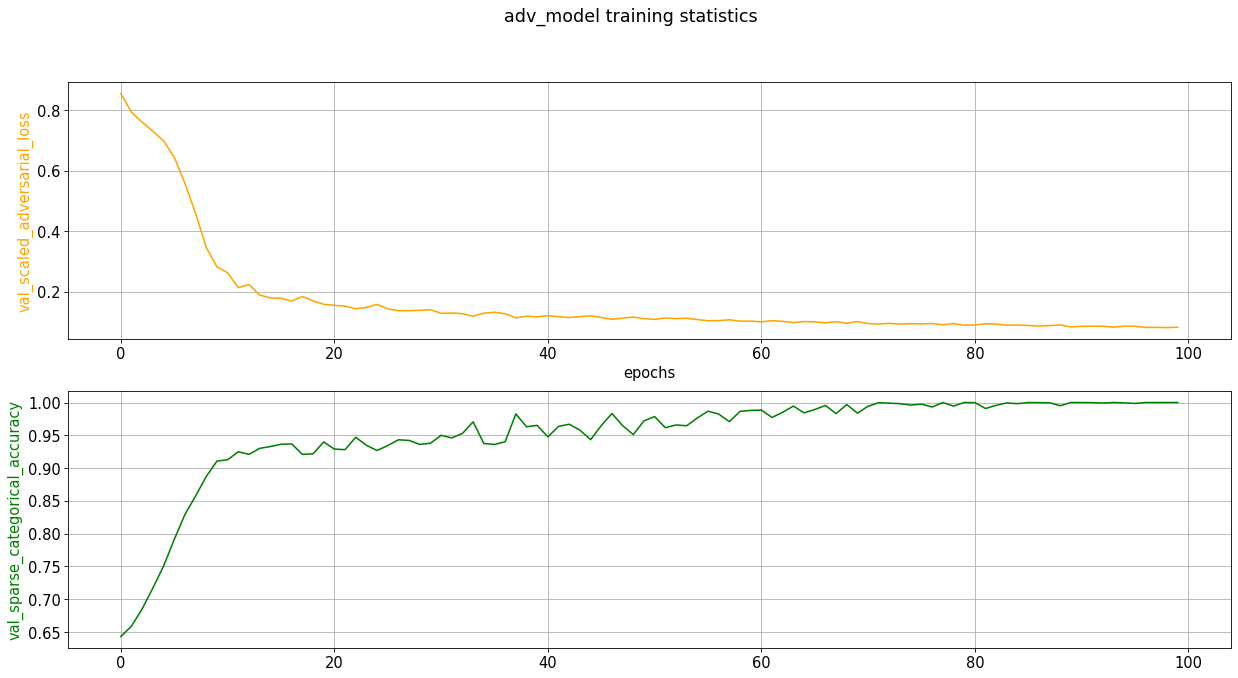

In [14]:
cm = 1 #1/2.54
nrows, ncols = 2, 1
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(20*ncols*cm, 5*nrows*cm), 
    sharex=False,
    sharey=False,
    dpi=75)

plt.suptitle(f"adv_model training statistics")

ax = axs[0]
ax.plot(adv_history.history['val_scaled_adversarial_loss'], color='orange')
ax.set_ylabel(f"val_scaled_adversarial_loss", color='orange')
ax.set_xlabel(f"epochs")
ax.grid(True)

ax = axs[1]
ax.plot(adv_history.history['val_sparse_categorical_accuracy'], color='green')
ax.set_ylabel(f"val_sparse_categorical_accuracy", color='green')
ax.grid(True)

In [15]:
adv_model.evaluate(x={'input': X_test, 'label': y_test})

68/68 [==============================] - 4s 54ms/step - loss: 0.1955 - sparse_categorical_accuracy: 1.0000 - sparse_categorical_crossentropy: 0.0769 - scaled_adversarial_loss: 0.0832


[0.19552190601825714,
 0.9999615550041199,
 0.07694250345230103,
 0.08320900052785873]

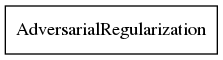

In [16]:
tf.keras.utils.plot_model(
    adv_model, 
    f"figures/GRU_classifier_adv_model.png", 
    show_shapes=True)

In [17]:
adv_model.summary()

Model: "AdversarialRegularization"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRU_classifier (Functional)  (None, None, 2)           11490     
Total params: 11,492
Trainable params: 11,490
Non-trainable params: 2
_________________________________________________________________


## methods for interpreting model predictions

### add temperature to pretrained model

In [18]:
T_layer = tf.keras.layers.Lambda(lambda x: x / args.temp, name='temperature')
S_layer = tf.keras.layers.Softmax(axis=-1, name='softmax')

In [19]:
model.trainable = False

t_model = tf.keras.Sequential(
    model.layers +\
    [T_layer, S_layer])

t_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

t_model.evaluate(X_test, y_test)

68/68 [==============================] - 1s 11ms/step - loss: 0.6789 - sparse_categorical_accuracy: 0.9947


[0.6788861751556396, 0.994731605052948]

In [20]:
t_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, None, 85)          0         
_________________________________________________________________
gru (GRU)                    (None, None, 32)          11424     
_________________________________________________________________
output (Dense)               (None, None, 2)           66        
_________________________________________________________________
temperature (Lambda)         (None, None, 2)           0         
_________________________________________________________________
softmax (Softmax)            (None, None, 2)           0         
Total params: 11,490
Trainable params: 0
Non-trainable params: 11,490
_________________________________________________________________


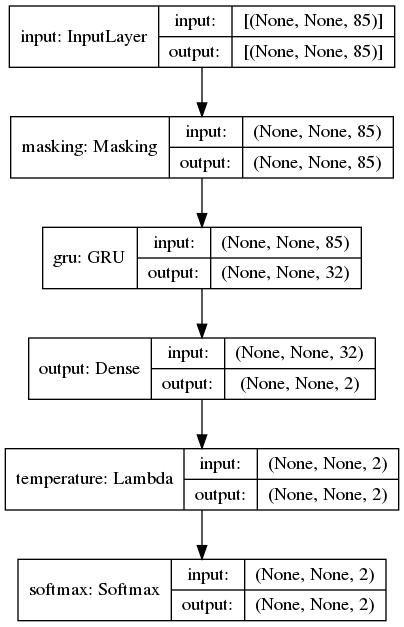

In [21]:
tf.keras.utils.plot_model(
    t_model, 
    f"figures/GRU_classifier_temp_model.png", 
    show_shapes=True)

In [22]:
adv_model.trainable = False

t_adv_model = tf.keras.Sequential(
    adv_model.layers +\
    [T_layer, S_layer])

t_adv_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

t_adv_model.evaluate(X_test, y_test)
y_pred = t_adv_model.predict(X_test)
# plt.hist(y_pred.flatten(), bins=1000)

68/68 [==============================] - 1s 11ms/step - loss: 0.6732 - sparse_categorical_accuracy: 1.0000


In [23]:
t_adv_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRU_classifier (Functional)  (None, None, 2)           11490     
_________________________________________________________________
temperature (Lambda)         (None, None, 2)           0         
_________________________________________________________________
softmax (Softmax)            (None, None, 2)           0         
Total params: 11,490
Trainable params: 0
Non-trainable params: 11,490
_________________________________________________________________


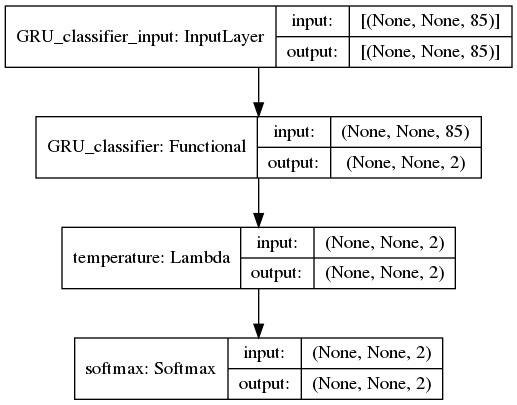

In [24]:
tf.keras.utils.plot_model(
    t_adv_model, 
    f"figures/GRU_classifier_temp_adv_model.png", 
    show_shapes=True)

### saliency

In [25]:
def compute_saliency_maps(model, fMRI_sequence, target_class_idx):
    '''
    compute saliency maps:
    1> pass fMRI_sequence to get class scores
    2> backpropagate class score of target class
    3> return gradients w.r.t. inputs
    '''
    target = np.expand_dims(np.array([0,0,0,0,0,0,0,1,1,1,1,1]),axis=0).astype(np.float64)
    fMRI_sequence = tf.convert_to_tensor(fMRI_sequence)
    with tf.GradientTape() as tape:
        tape.watch(fMRI_sequence)
        probs = model(fMRI_sequence)[:, :, target_class_idx] # class probability score of the target class
    return tape.gradient(probs, fMRI_sequence).numpy()

In [55]:
def unmask_ROIwise(x, mask):
    '''
    input:
    -----
    x: np.array of size <num_time, num_rois>
    mask: nilearn niimg of size <num_vox_x, num_vox_y, num_vox_z>
    
    output:
    ------
    final_mask: nilearn niimg that contains the unmasked 4D 
                volumetric data of x
    '''
    mask_data = mask.get_fdata().copy()
    s = list(mask_data.shape) + list(x.shape[:-1])
    final_data = np.zeros(shape=s, dtype=np.float32)
    
    mask_data = np.expand_dims(mask_data, axis=-1)
    num_rois = np.int(np.max(mask_data))
    
    for idx_roi in np.arange(num_rois):
        
        roi_data = x[:, idx_roi] * (mask_data==(idx_roi+1))
        final_data += roi_data
        
    final_mask = image.new_img_like(ref_niimg=mask, 
                              data=final_data, 
                              copy_header=False)
    return final_mask
        

In [56]:
normalize = lambda a: (a - np.mean(a)) / np.std(a)
MAX85 = image.load_img(img=f"/home/govindas/parcellations/MAX_85_ROI_masks/MAX_ROIs_final_gm_85.nii.gz")

appr_TR = 7
saliency_appr = []
saliency_retr = []
for idx_sample in tqdm(range(X_test.shape[0])):

    sample = np.expand_dims(X_test[idx_sample, :, :], axis=0)
    
    # approach class
    sample_saliency = compute_saliency_maps(
        model=t_model, 
        fMRI_sequence=sample, 
        target_class_idx=0)
    sample_saliency = normalize(sample_saliency)
    saliency_appr.append(sample_saliency)
    
    # retreat class
    sample_saliency = compute_saliency_maps(
        model=t_model, 
        fMRI_sequence=sample, 
        target_class_idx=1)
    sample_saliency = normalize(sample_saliency)
    saliency_retr.append(sample_saliency)

mean_saliency_appr = np.mean(np.vstack(saliency_appr), axis=0)
mean_saliency_retr = np.mean(np.vstack(saliency_retr), axis=0)
# saliency_contrast = mean_saliency_appr - mean_saliency_retr

sal_appr_niimg = unmask_ROIwise(mean_saliency_appr, MAX85)
sal_retr_niimg = unmask_ROIwise(mean_saliency_retr, MAX85)

# sal_nii_list = []
# for t in range(mean_saliency_appr.shape[0]):
#     sal_nii_list.append(unmask_ROIwise(saliency_contrast[t], MAX85))
# mean_saliency_appr = concat_imgs(sal_nii_list)
# mean_saliency_appr.to_filename('nifti_files/MAX85_sal_contrast.nii.gz') 


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2167/2167 [07:34<00:00,  4.77it/s]


In [58]:
sal_appr_niimg.to_filename(f"{month_dir}/figures/saliency_approach.nii.gz")
sal_retr_niimg.to_filename(f"{month_dir}/figures/saliency_retreat.nii.gz")